# Исследование объявлений о продаже квартир

В проекте рассмотрим архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет (данные сервиса Яндекс.Недвижимость).

Главная цель - установить параметры, оказывающие наибольшее влияние на стоимость объекта для дальнейшего автоматического прогнозирования рыночной стоимости недвижимости.

Проект состоит из двух частей:
- предобработка данных (выявление пропусков, выбросов и дубликатов);
- исследовательский анализ данных (выявление влияние параметров на стоимость объекта).

### Откройте файл с данными и изучите общую информацию. 

In [1]:
# импортируем необходимые библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import math

In [2]:
# прочитаем csv-файл
data = pd.read_csv('https://code.s3.yandex.net/datasets/real_estate_data.csv', sep='\\t', engine='python')

# выведем первые 5 строк
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


**Посмотрим общую информацию по датасету**

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [4]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
total_images,23699.0,9.858475e+00,5.682529e+00,0.0,6.00,9.00,14.0,50.0
last_price,23699.0,6.541549e+06,1.088701e+07,12190.0,3400000.00,4650000.00,6800000.0,763000000.0
total_area,23699.0,6.034865e+01,3.565408e+01,12.0,40.00,52.00,69.9,900.0
rooms,23699.0,2.070636e+00,1.078405e+00,0.0,1.00,2.00,3.0,19.0
ceiling_height,14504.0,2.771499e+00,1.261056e+00,1.0,2.52,2.65,2.8,100.0
floors_total,23613.0,1.067382e+01,6.597173e+00,1.0,5.00,9.00,16.0,60.0
living_area,21796.0,3.445785e+01,2.203045e+01,2.0,18.60,30.00,42.3,409.7
floor,23699.0,5.892358e+00,4.885249e+00,1.0,2.00,4.00,8.0,33.0
kitchen_area,21421.0,1.056981e+01,5.905438e+00,1.3,7.00,9.10,12.0,112.0
balcony,12180.0,1.150082e+00,1.071300e+00,0.0,0.00,1.00,2.0,5.0


Построим гистрограммы для каждого столбца

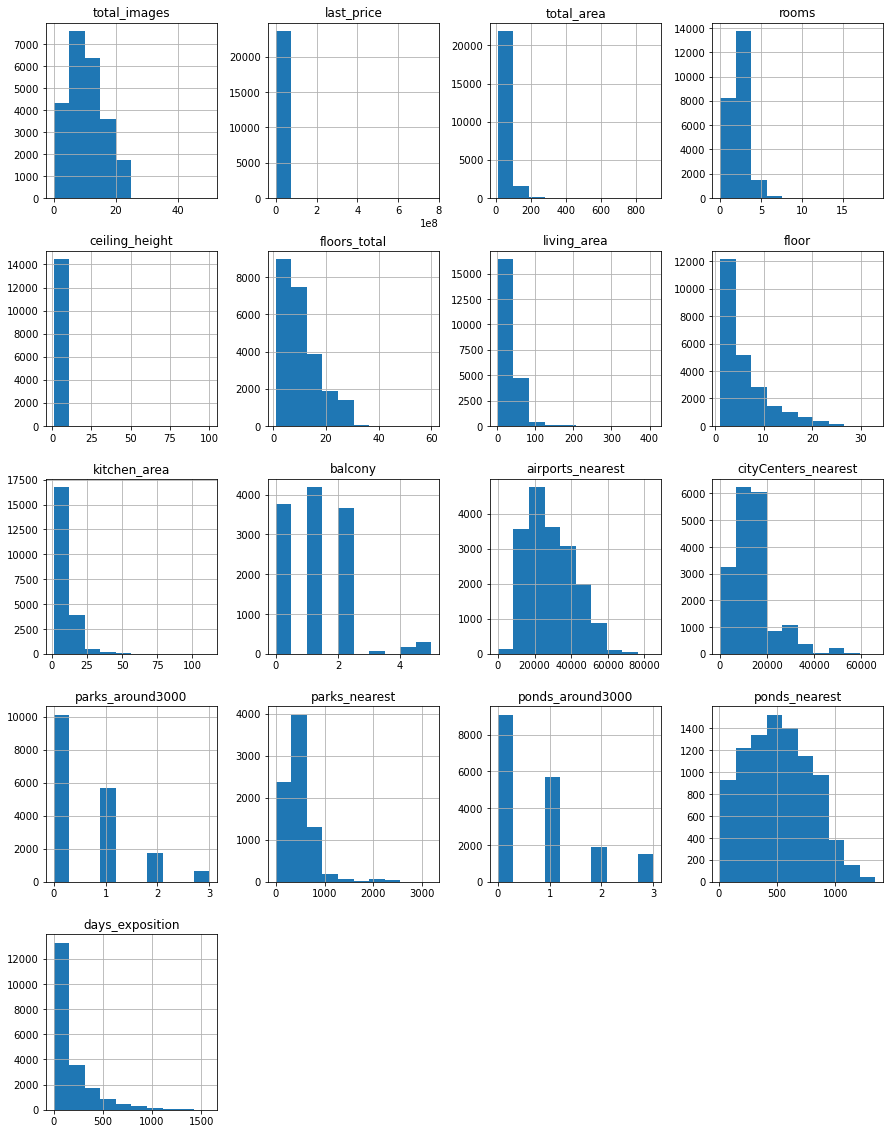

In [5]:
data.hist(figsize=(15, 20));

- всего в исходной выборке 23699 строк. Однако есть столбцы с достаточно большим количеством пропусков;
- больше половины значений пропущено в столбцах: balcony, parks_nearest, ponds_nearest;
- на первый взгляд,, достаточно сильные выбросы есть в столбцах: last_price, ceiling_height, total_area, living_area, kitchen_area, rooms. 

### Предобработка данных

**Обработка пропущенных значений**

Посмотрим, сколько пропусков в каждом столбце

In [6]:
data.isna().sum().sort_values()

total_images                0
open_plan                   0
floor                       0
rooms                       0
studio                      0
total_area                  0
last_price                  0
first_day_exposition        0
locality_name              49
floors_total               86
living_area              1903
kitchen_area             2278
days_exposition          3181
ponds_around3000         5518
parks_around3000         5518
cityCenters_nearest      5519
airports_nearest         5542
ceiling_height           9195
balcony                 11519
ponds_nearest           14589
parks_nearest           15620
is_apartment            20924
dtype: int64

Больше всего пропущенных значений в столбце _is_apartment_.

В этом столбце только 2 варианта значения: 1 (_значит, да_) и 0 (_значит, нет_).

В таком случае, логично заменить пропущеные значения на 0 (_нет_).

In [7]:
data['is_apartment'] = data['is_apartment'].fillna(0)

Пропуски в столбце balcony, скорее всего, связаны с тем, что в квартире балконов нет. Меняем пропуски на 0.

In [8]:
data['balcony'] = data['balcony'].fillna(0)

Подобрать значения для замены пропусков в столбцах _ponds_nearest_, _parks_nearest_, _ceiling_height_, _airports_nearest_ и _cityCenters_nearest_ на основе имеющихся данных невозможно. Поэтому оставим пропуски пропусками.

_В качестве варианта решения:_ можно дополнительно запросить выгрузку с адресами объектов и затем по аналогичным адресам в базе данных определить высоту потолков, расстояния до центра, ближайшего аэропорта, парка и водоёма. В определении высоты потолков нужно будет на всякий случай учитывать и этаж объекта.

Пропуски в столбцах _ponds_around3000_ и _parks_around3000_, скорее всего, связаны с отсутствием поблизости прудов и парков.

Заменим в этих столбцах пропуски на 0.

In [9]:
data['ponds_around3000'] = data['ponds_around3000'].fillna(0)
data['parks_around3000'] = data['parks_around3000'].fillna(0)

Пропуски в столбце _days_exposition_, скорее всего, связаны с тем, что на момент выгрузки объект еще не продан.

Оставим пропуски пропусками. Возможно, в других столбцах этих записей есть ценная информация.

Предложить замены для всех пропусков в столбцах _kitchen_area_ и _living_area_ сложно. Возможно, продавец пропустил заполнение этих полей по невнимательности, а возможно, умышленно не захотел указывать - что уже может вызвать некоторые подозрения. Но пока оставим строки с пропусками в этих столбцах в общем датасете.

В колонке _floors_total_ заменить пропуски, не зная адреса, тоже невозможно. 

Скорее всего, их не указали сами пользователи. Но вряд ли продавец не знает этажность дома. 

Таких записей - 0,3% от общего числа, некритичным будет удалить их даже на этом этапе.

In [10]:
data = data.dropna(subset=['floors_total'])

В столбце _locality_name_ всего 49 пропусков - это 0,2% от общего числа записей.

В то же время фактор расположения в значительной степени определяет стоимость объекта. 

Удалим записи с пропусками в этом столбце.

In [11]:
data = data.dropna(subset=['locality_name'])

In [12]:
# посмотрим на результат обработки пропусков
data.isna().sum().sort_values()

total_images                0
ponds_around3000            0
parks_around3000            0
locality_name               0
balcony                     0
open_plan                   0
is_apartment                0
floor                       0
studio                      0
floors_total                0
rooms                       0
first_day_exposition        0
total_area                  0
last_price                  0
living_area              1865
kitchen_area             2222
days_exposition          3171
cityCenters_nearest      5501
airports_nearest         5524
ceiling_height           9084
ponds_nearest           14529
parks_nearest           15535
dtype: int64

Посмотрим, какой выборка стала теперь.

In [13]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
total_images,23565.0,9.878421e+00,5.681156e+00,0.0,6.00,9.00,14.0,50.0
last_price,23565.0,6.540058e+06,1.091093e+07,12190.0,3400000.00,4646000.00,6790000.0,763000000.0
total_area,23565.0,6.032282e+01,3.565706e+01,12.0,40.00,52.00,69.7,900.0
rooms,23565.0,2.070656e+00,1.078591e+00,0.0,1.00,2.00,3.0,19.0
ceiling_height,14481.0,2.771283e+00,1.261983e+00,1.0,2.51,2.65,2.8,100.0
floors_total,23565.0,1.067588e+01,6.594823e+00,1.0,5.00,9.00,16.0,60.0
living_area,21700.0,3.445482e+01,2.204536e+01,2.0,18.60,30.00,42.3,409.7
floor,23565.0,5.878124e+00,4.871485e+00,1.0,2.00,4.00,8.0,33.0
kitchen_area,21343.0,1.056099e+01,5.900630e+00,1.3,7.00,9.10,12.0,112.0
balcony,23565.0,5.936771e-01,9.606601e-01,0.0,0.00,0.00,1.0,5.0


По количеству значений видно, что все отработало так, как и планировалось:
- сохранилось 99,4% от исходных данных;
- осталось 8 столбцов с пропусками. Изначально таких столбцов было 14. 

*Думаю, в реальной ситуации правильным решением было бы составить баг-репорт:*
- указать все столбцы с пропусками;
- предложить добавить адрес для уточнения высоты потолков, общего количества этажей и расстояний до центра, аэропорта, водоемов, парков, пока не починят автоматический расчет этих метрик.

**Изменение типов данных**

Заменим типы данных в следующих столбцах:
- _first_day_exposition_ на datetime, так как это дата;
- _floors_total_ на uint8, так как могут быть только целые этажи;
- _is_apartment_ на bool, так как принимается только два значения;
- _balcony_ на uint8, так как количество балконов всегда целое число;
- _parks_around3000_ на uint8, так как количество парков всегда целое число;
- _ponds_around3000_ на uint8, так как количество водоёмов всегда целое число;
- _days_exposition_ на uint8, так как разница между датами подсчитывается целыми днями;
- столбцы с типом данных float64 на float32;
- столбцы с типом данных int64 на uint8.

In [14]:
# перевод first_day_exposition в формат даты и времени
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')

# перевод is_apartment в булевый формат
data['is_apartment'] = data['is_apartment'] == True

# перевод floors_total, balcony, parks_around3000, ponds_around3000, days_exposition в целочисленный формат
for col in ['floors_total', 'balcony', 'parks_around3000', 'ponds_around3000', 'days_exposition']:
    data[col] = data[col].astype('uint8', errors='ignore')

# перевод float64 в float32 и int64 в uint8 
for col in data.columns:
    if data[col].dtype == 'float64':
        data[col] = data[col].astype('float32', errors='ignore')
    elif data[col].dtype == 'int64':
        data[col] = data[col].astype('uint8', errors='ignore')

Проверим результат изменения типов в столбцах

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23565 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23565 non-null  uint8         
 1   last_price            23565 non-null  float32       
 2   total_area            23565 non-null  float32       
 3   first_day_exposition  23565 non-null  datetime64[ns]
 4   rooms                 23565 non-null  uint8         
 5   ceiling_height        14481 non-null  float32       
 6   floors_total          23565 non-null  uint8         
 7   living_area           21700 non-null  float32       
 8   floor                 23565 non-null  uint8         
 9   is_apartment          23565 non-null  bool          
 10  studio                23565 non-null  bool          
 11  open_plan             23565 non-null  bool          
 12  kitchen_area          21343 non-null  float32       
 13  balcony         

**Обработка неявных дубликатов в столбце с названиями**

Посмотрим уникальных значения 

In [16]:
sorted(data['locality_name'].unique())

['Бокситогорск',
 'Волосово',
 'Волхов',
 'Всеволожск',
 'Выборг',
 'Высоцк',
 'Гатчина',
 'Зеленогорск',
 'Ивангород',
 'Каменногорск',
 'Кингисепп',
 'Кириши',
 'Кировск',
 'Колпино',
 'Коммунар',
 'Красное Село',
 'Кронштадт',
 'Кудрово',
 'Лодейное Поле',
 'Ломоносов',
 'Луга',
 'Любань',
 'Мурино',
 'Никольское',
 'Новая Ладога',
 'Отрадное',
 'Павловск',
 'Петергоф',
 'Пикалёво',
 'Подпорожье',
 'Приморск',
 'Приозерск',
 'Пушкин',
 'Санкт-Петербург',
 'Светогорск',
 'Сертолово',
 'Сестрорецк',
 'Сланцы',
 'Сосновый Бор',
 'Сясьстрой',
 'Тихвин',
 'Тосно',
 'Шлиссельбург',
 'городской поселок Большая Ижора',
 'городской поселок Янино-1',
 'городской посёлок Будогощь',
 'городской посёлок Виллози',
 'городской посёлок Лесогорский',
 'городской посёлок Мга',
 'городской посёлок Назия',
 'городской посёлок Новоселье',
 'городской посёлок Павлово',
 'городской посёлок Рощино',
 'городской посёлок Свирьстрой',
 'городской посёлок Советский',
 'городской посёлок Фёдоровское',
 'городск

Удалим тип населенного пункта (село, посёлок, садовое товарищество и т.д.) - сохраним новые названия в столбце city_name.

In [17]:
# создадим функцию, которая возвращает только навзание населенного пункта, без его типа
def delete_city_type(data):
    types = ['село ', 'садовое товарищество ', 'садоводческое некоммерческое товарищество ', 
             'деревня ', 'коттеджный посёлок ', 'коттеджный поселок ', 'городской посёлок ', 'городской поселок ', 
             'посёлок городского типа ', 'поселок городского типа ', 'посёлок при железнодорожной станции ', 
             'посёлок станции ', 'посёлок ', 'поселок ']
    only_name = data['locality_name'].copy()
    for type in types:
        only_name = only_name.str.replace(type, '')
    return only_name

data['city_name'] = delete_city_type(data)
sorted(data['city_name'].unique())

['Агалатово',
 'Александровская',
 'Алексеевка',
 'Аннино',
 'Аро',
 'Барышево',
 'Батово',
 'Бегуницы',
 'Белогорка',
 'Белоостров',
 'Бокситогорск',
 'Большая Вруда',
 'Большая Ижора',
 'Большая Пустомержа',
 'Большие Колпаны',
 'Большое Рейзино',
 'Большой Сабск',
 'Бор',
 'Борисова Грива',
 'Бугры',
 'Будогощь',
 'Ваганово',
 'Важины',
 'Вартемяги',
 'Вахнова Кара',
 'Вещево',
 'Виллози',
 'Вознесенье',
 'Возрождение',
 'Войсковицы',
 'Войскорово',
 'Володарское',
 'Волосово',
 'Волхов',
 'Всеволожск',
 'Выборг',
 'Вырица',
 'Выскатка',
 'Высокоключевой',
 'Высоцк',
 'Гаврилово',
 'Гарболово',
 'Гатчина',
 'Гладкое',
 'Глажево',
 'Глебычево',
 'Глинка',
 'Гончарово',
 'Горбунки',
 'Гостилицы',
 'Громово',
 'Дзержинского',
 'Дружная Горка',
 'Дружноселье',
 'Дубровка',
 'Елизаветино',
 'Ефимовский',
 'Жилгородок',
 'Жилпосёлок',
 'Житково',
 'Заводской',
 'Заклинье',
 'Заневка',
 'Запорожское',
 'Зеленогорск',
 'Зимитицы',
 'Ивангород',
 'Извара',
 'Ильичёво',
 'Иссад',
 'Калитино',

В списке уникальных значений встречаются несколько похожих названий. Однако, судя по Яндекс.Картам, все они являются разными населенными пунктами.

Только населенного пункта "Коммунары" не нашлось, поэтому переименуем его в "Коммунар", который, действительно, существует.

In [18]:
data.loc[data['city_name'] == 'Коммунары', 'city_name'] = 'Коммунар'

**Устранение выбросов**

Посмотрим распределение значений в last_price

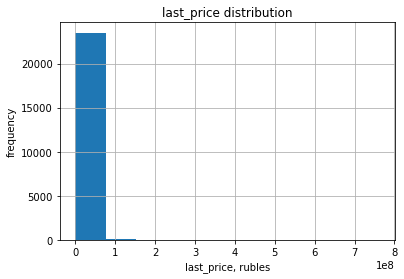

In [19]:
hist = data.hist('last_price')
plt.title('last_price distribution')
plt.xlabel('last_price, rubles')
plt.ylabel('frequency')
plt.show()

По гистограмме видно, что присутствуют редкие выбивающиеся значения. Попробуем отсечь 1% минимальных и 1% максимальных значений.

In [20]:
# функция для построения гистрограммы по отфильтрованным данным
def create_hist(column, dimension, l_border, r_border):
    l = data[column].quantile(l_border) # персентиль по заданному столбцу по левой границе
    r = data[column].quantile(r_border) # персентиль по заданному столбцу по правой границе
    hist = data[data[column].between(l,r)].hist(column) 
    plt.title(f'{column} distribution')
    plt.xlabel(f'{column}, {dimension}')
    plt.ylabel('frequency')
    plt.show()

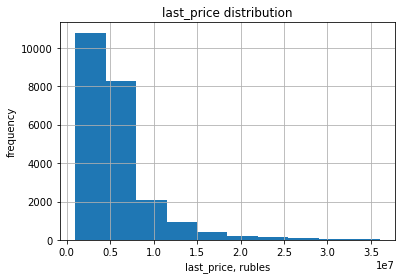

In [21]:
# отфильтруем 1% минимальных и 1% максимальных значений в last_price
create_hist('last_price', 'rubles', 0.01, 0.99) 

Распределение стало более наглядным, а потеряли мы всего 2%. 

Скорректируем нашу выборку по столбцу _last_price_.

In [22]:
l = data['last_price'].quantile(0.01)
r = data['last_price'].quantile(0.99)
data = data[data['last_price'].between(l,r)]

Посмотрим распределение значений в total_area

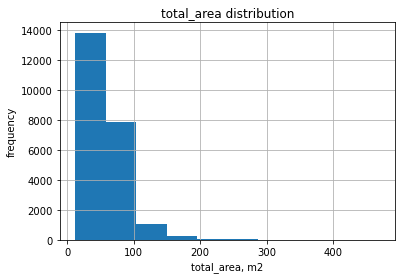

In [23]:
create_hist('total_area', 'm2', 0, 1)

Отфильтруем 1% максимальных в total_area

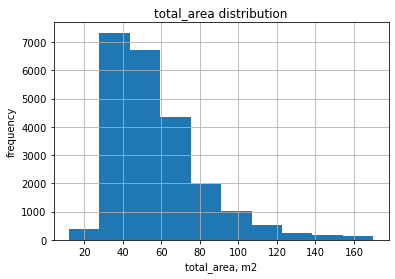

In [24]:
create_hist('total_area', 'm2', 0, 0.99) 

Удалим из нашего датасета 1% максимальных значений в столбце _total_area_.

In [25]:
r = data['total_area'].quantile(0.99)
data = data[data['total_area'].between(0, r)]

Посмотрим распределение значений в rooms.

In [26]:
data['rooms'].value_counts().sort_values()

8       1
7      13
6      42
0     192
5     219
4    1064
3    5661
2    7786
1    7900
Name: rooms, dtype: int64

0 комнат - смотрится странно.

Посмотрим на объявления с 0 комнат подробнее.

In [27]:
data[data['rooms'] == 0].describe().T

,count,mean,std,min,25%,50%,75%,max
total_images,192.0,7.880208e+00,5.097091e+00,0.0,4.000000e+00,7.000,1.100000e+01,2.100000e+01
last_price,192.0,3.004615e+06,1.418083e+06,1100000.0,2.300000e+06,2700000.000,3.385000e+06,1.630000e+07
total_area,192.0,2.759329e+01,8.427867e+00,15.5,2.408750e+01,26.075,2.832500e+01,9.840000e+01
rooms,192.0,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000,0.000000e+00,0.000000e+00
ceiling_height,80.0,3.102750e+00,2.732122e+00,2.5,2.700000e+00,2.745,2.800000e+00,2.700000e+01
floors_total,192.0,1.702083e+01,6.850657e+00,3.0,1.200000e+01,17.000,2.325000e+01,3.500000e+01
living_area,182.0,1.889912e+01,6.551498e+00,2.0,1.600000e+01,18.000,1.997500e+01,6.800000e+01
floor,192.0,8.583333e+00,6.324003e+00,1.0,3.000000e+00,7.000,1.300000e+01,2.600000e+01
kitchen_area,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
balcony,192.0,1.036458e+00,9.230747e-01,0.0,0.000000e+00,1.000,2.000000e+00,2.000000e+00


Выделяется отсутствие значений площади кухни. Проверим: возможно, это студии или квартиры с открытой планировкой.

In [28]:
for col in ['studio', 'open_plan']:
    print(data[data['rooms'] == 0][col].count())

192
192


Посмотрим распределение значений в ceiling_height.

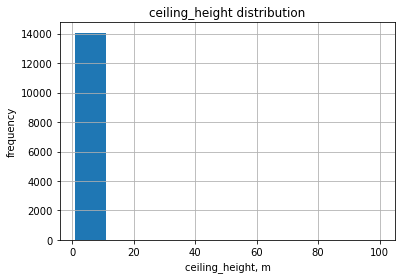

In [29]:
create_hist('ceiling_height', 'm', 0, 1) 

Посмотрим распределение двузначных значений в ceiling_height

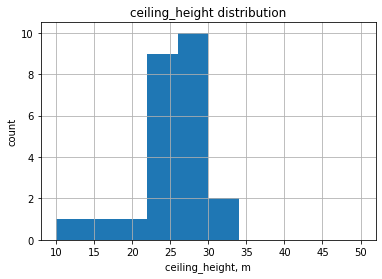

In [30]:
hist = data.hist('ceiling_height', range=(10, 50)) 
plt.title('ceiling_height distribution')
for ax in hist.flatten():
    ax.set_xlabel('ceiling_height, m')
    ax.set_ylabel('count')

Заменим в ceiling_height 25 на 2.5 и 32 на 3.2

In [31]:
data['ceiling_height'] = data['ceiling_height'].replace(25, 2.5)
data['ceiling_height'] = data['ceiling_height'].replace(32, 3.2)

Отфильтруем 1% минимальных и 1% максимальных значений в ceiling_height

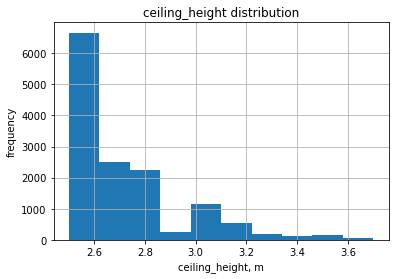

In [32]:
create_hist('ceiling_height', 'm', 0.01, 0.99)

Заменили 25 и 32 на 2.5 и 3.2, соотвественно. Удалили по 1% самых маленьких и самых больших значений.

В результате получили адекватные значения высоты потолков.

Скорректируем нашу выборку

In [33]:
l = data['ceiling_height'].quantile(0.01)
r = data['ceiling_height'].quantile(0.99)
# из-за наличия пропусков, чтобы не потерять в объеме данных, приходится делать такое "двойное" отрицание
data = data[-(data['ceiling_height'] > r)] 
data = data[-(data['ceiling_height'] < l)]

Посмотрим распределение значений в floors_total.

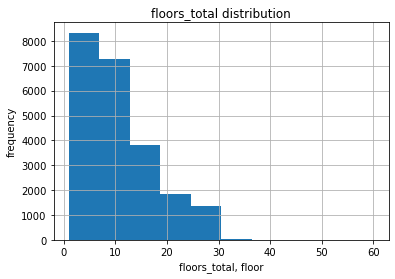

In [34]:
create_hist('floors_total', 'floor', 0, 1)

В нашей выборке есть и квартиры из небоскребов.

Посмотрим распределение значений в living_area

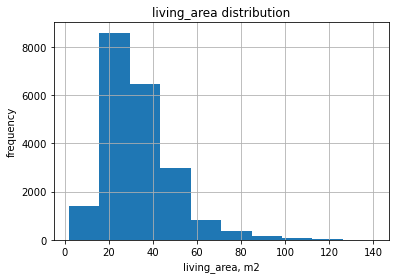

In [35]:
create_hist('living_area', 'm2', 0, 1)

Значения и их размах похожи на правду. По этому столбцу дополнительно фильтровать не будем.

Посмотрим на столбец _floor_:
- сначала посмотрим нет ли записей, где этаж больше общего количества этажей в здании. Если такие попадутся, их удалим.
- затем посмотрим на распределение значений.

In [36]:
data[data['floor'] > data['floors_total']]['floor'].sum()

0

Записей, где этаж больше общего количества этажей, нет.

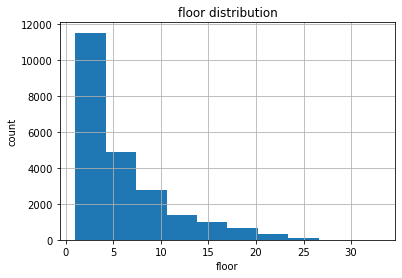

In [37]:
hist = data.hist('floor') 
plt.title('floor distribution')
for ax in hist.flatten():
    ax.set_xlabel('floor')
    ax.set_ylabel('count')

Размах значений выглядит правдоподобно. Менять здесь ничего не будем.

Посмотрим распределение значений в kitchen_area

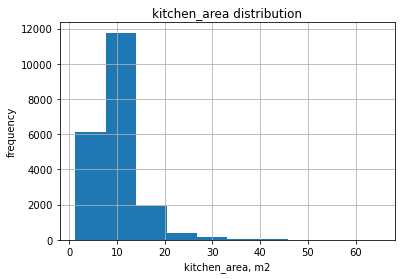

In [38]:
create_hist('kitchen_area', 'm2', 0, 1)

In [39]:
len(data[data['kitchen_area'] == data['living_area']])

39

In [40]:
data = data[data['kitchen_area'] != data['living_area']]

Посмотрим распределение значений в balcony

In [41]:
data['balcony'].value_counts().sort_values()

3       74
4      172
5      292
2     3590
1     4024
0    14484
Name: balcony, dtype: int64

Явных выбросов нет - оставляем все, как есть.

Посмотрим распределение значений в airports_nearest

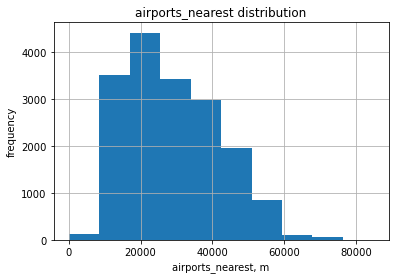

In [42]:
create_hist('airports_nearest', 'm', 0, 1)

Явных выбросов нет - оставляем все, как есть.

Посмотрим распределение значений в cityCenters_nearest

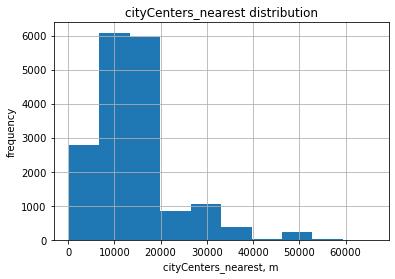

In [43]:
create_hist('cityCenters_nearest', 'm', 0, 1)

Гистрограмма выглядит логично: в центре города живет сильно меньше людей, чем на окраинах. Потом город заканчивается и плотность населения резко снижается.

Посмотрим распределение значений в parks_around3000

In [44]:
data['parks_around3000'].value_counts()

0    15042
1     5444
2     1600
3      550
Name: parks_around3000, dtype: int64

Все логично: у большинства - ни одного парка вокруг, лишь немногим повезло иметь поблизости целых 3.

Посмотрим распределение значений в parks_nearest

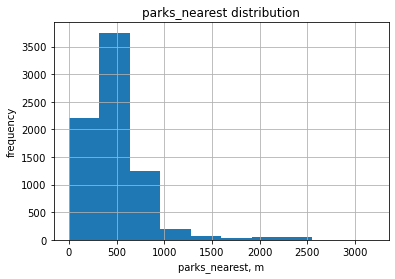

In [45]:
create_hist('parks_nearest', 'm', 0, 1)

По графику распределение похоже на пуассоновское. Явных выбросов нет. Оставляем все, как есть.

In [46]:
data['ponds_around3000'].value_counts()

0    14051
1     5468
2     1773
3     1344
Name: ponds_around3000, dtype: int64

Ситуация аналогична ситуации с парками: водоемов поблизости у большинства нет. 

Посмотрим распределение значений в ponds_nearest

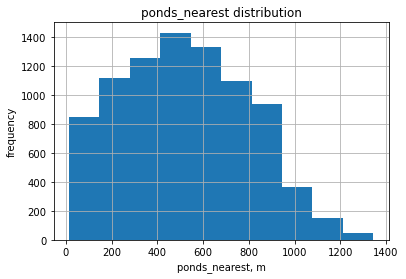

In [47]:
create_hist('ponds_nearest', 'm', 0, 1)

Явных выбросов нет.

Визуально график напоминает график пуассоновского распределения.

Посмотрим распределение значений в days_exposition

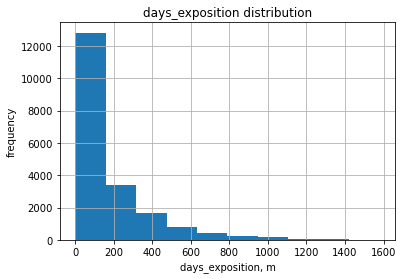

In [48]:
create_hist('days_exposition', 'm', 0, 1)

Явных выбросов нет. Однако было бы интересно посмотреть, как распределяются значения в диапазоне от 0 до 100

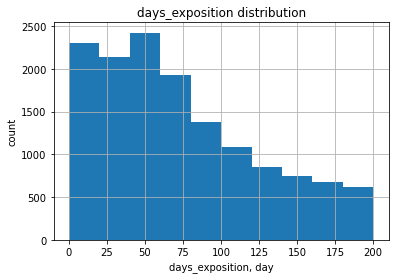

In [49]:
hist = data.hist('days_exposition', range=(0, 200)) 
plt.title('days_exposition distribution')
for ax in hist.flatten():
    ax.set_xlabel('days_exposition, day')
    ax.set_ylabel('count')

Посмотрим, какие значения встречаются наиболее часто.

In [50]:
data['days_exposition'].value_counts().sort_values(ascending=False).head()

45.0    832
60.0    536
7.0     230
30.0    203
90.0    178
Name: days_exposition, dtype: int64

Есть выделяющиеся значения: 45 и 60 дней. Они встречаются чаще других в 2-3 раза. 

Очень похоже на аномалии в данных. Предположим, что такие значения могут быть обусловлены алгоритмом работы самого сервиса, который после 45 и 60 дней (возможно, разные категории объявлений) автоматически удаляет объявления, если пользователь их не продлевает.

В реальной ситуации, правильнее было бы сначала уточнить эту информацию, а затем принимать решение, как поступить с этими значениями в нашей выборке. В нашем случае, добавим столбец с флагом автоснятия _auto_droped_. 

In [51]:
data['auto_droped'] = data['days_exposition'].apply(lambda x: True if x in [45, 60] else False)

В исходных данных было 23699 строк. После выполненной предобработки осталось 22636.

Убрали большую часть пропусков, избавились от выбросов и аномалий и вместе с тем сохранили 95,5% от исходных данных.

<div class="alert alert-block alert-warning">
<b>⚠️ Remarks:</b> будет лучше не просто их снести, а заменить каким-то флагом и отнести к той же группе, что и нулевые значения - т.е не проданные квартиры. В перспективе эти данные можно отдельно поизучать и накопать инсайтов, почему квартиры не продаются, чем они отличаются от продающихся итд

### Посчитайте и добавьте в таблицу новые столбцы

Добавим столбец с ценой квадратного метра: разделим цену на момент снятия объявления с продажи на общую площадь.

In [52]:
data['m2_price'] = data['last_price'] / data['total_area']

Добавим столбец  с днем недели публикации объявления.

In [53]:
data['weekday_exposition'] = data['first_day_exposition'].dt.dayofweek

Добавим столбец с месяцем публикации объявления.

In [54]:
data['month_exposition'] = pd.DatetimeIndex(data['first_day_exposition']).month

Добавим столбец с годом публикации объявления.

In [55]:
data['year_exposition'] = pd.DatetimeIndex(data['first_day_exposition']).year

Добавим столбец с типом этажа квартиры (значения — «‎первый», «последний», «другой»).

In [56]:
# создадим функцию для определения типа этажа
def get_floor_type(data):
    if data['floor'] == 1:
        return 'первый'
    if data['floor'] == data['floors_total']:
        return 'последний'
    return 'другой'

# применим функцию к нашей выборке    
data['floor_type'] = data.apply(get_floor_type, axis=1)

Добавим столбец расстоянием до центра города в километрах.

In [57]:
data['cityCenters_nearest_km'] = data['cityCenters_nearest'].apply(lambda x: x if math.isnan(x) else round(x / 1000)) 

### Проведите исследовательский анализ данных

Подробнее рассмотрим распределение значений в следующий столбцах:
- общая площадь;
- жилая площадь;
- площадь кухни;
- цена объекта;
- количество комнат;
- высота потолков;
- этаж квартиры;
- тип этажа квартиры («первый», «последний», «другой»);
- общее количество этажей в доме;
- расстояние до центра города в метрах;
- расстояние до ближайшего аэропорта;
- расстояние до ближайшего парка;
- день и месяц публикации объявления.

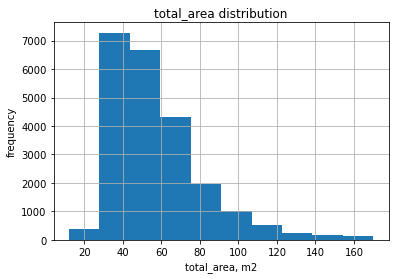

In [58]:
create_hist('total_area', 'm2', 0, 1)

In [59]:
data['total_area'].value_counts().sort_values(ascending=False).head()

45.0    404
42.0    369
60.0    339
31.0    334
44.0    332
Name: total_area, dtype: int64

In [60]:
print('max =', data['total_area'].max())
print('min =', data['total_area'].min())

max = 170.0
min = 12.0


Распределение по графику похоже на пуассоновское.

Наиболее часто встречающиеся общие площади: 45 м2 и 42 м2.

Максимальная общая площадь: 162,2 м2.

Минимальная общая площадь: 12,0 м2. 

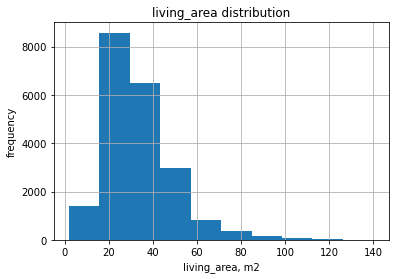

In [61]:
create_hist('living_area', 'm2', 0, 1)

По графику распределение также похоже на пуассоновское.

Но наблюдается довольно резкий провал в диапазоне значений от 20 до 25 и два ярко выраженных максимума: в даипазоне от 15 до 20 и от 30 до 35. 
Рассмотрим этот интервал подробнее.

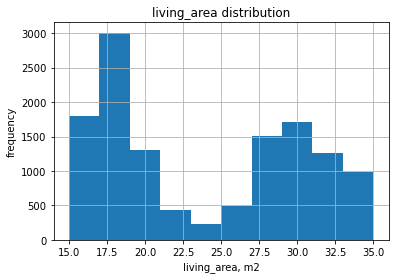

In [62]:
hist = data.hist('living_area', range=(15, 35)) 
plt.title('living_area distribution')
plt.xlabel('living_area, m2')
plt.ylabel('frequency');

Можно  предположить, что в Ленинградской области очень много типовых квартир с жилой площадью 16-18 м2 и 29-31 м2.

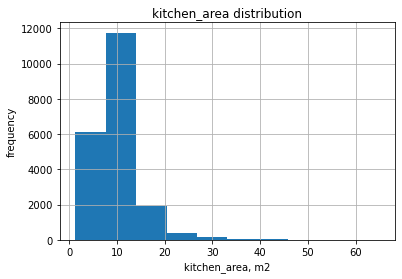

In [63]:
create_hist('kitchen_area', 'm2', 0, 1)

Наиболее распространненные площади кухонь 6-12 м2.

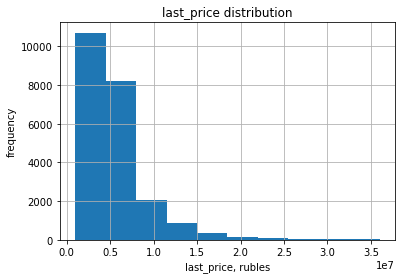

In [64]:
create_hist('last_price', 'rubles', 0, 1)

Из-за очень высоких цен сложно рассмотреть наиболее часто встречающиеся.

Построим дополнительную гистрограмму, исключив 1% самых больших значений.

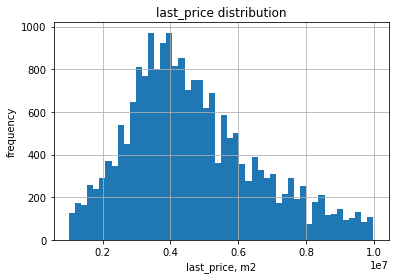

In [65]:
hist = (data[data['last_price'] <= data['last_price'].quantile(0.9)]
        .hist('last_price', bins=50)
) 
plt.title('last_price distribution')
plt.xlabel('last_price, m2')
plt.ylabel('frequency');

In [66]:
print('max ', data['last_price'].max())
print('min ', data['last_price'].min())

max  36000000.0
min  1000000.0


Максимальная стоимость объекта в нашей выборке - 36 млн рублей.

Минимальная стоимость - 1 млн рублей.

Наиболее часто встречаются цены объектов в диапазоне от 3 млн до 5 млн.

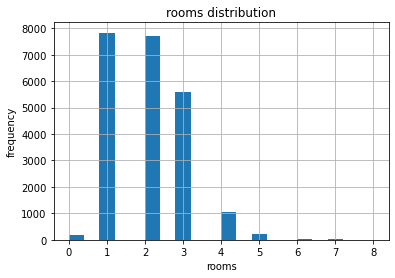

In [67]:
hist = data.hist('rooms', bins=20)
plt.title('rooms distribution')
plt.xlabel('rooms')
plt.ylabel('frequency');

Выглядит правдоподобно:
- однушки и двушки - самый популярный сегмент;
- 5-8 комнат - почти не найти.

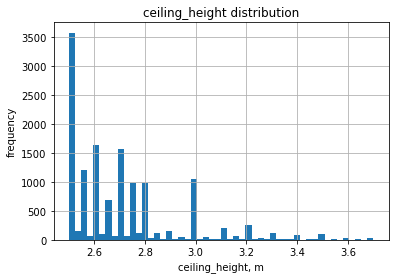

In [68]:
hist = data.hist('ceiling_height', bins=50)
plt.title('ceiling_height distribution')
plt.xlabel('ceiling_height, m')
plt.ylabel('frequency');

Самые распространенные высоты потолков - в диапазоне от 2,5 до 2,8 м. Также выделяются значения в 3 м. 

Скорее всего, это типовые параметры для многоэтажек.

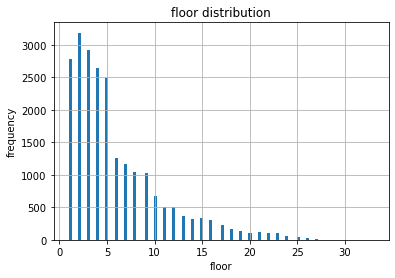

In [69]:
hist = data.hist('floor', bins=100)
plt.title('floor distribution')
plt.xlabel('floor')
plt.ylabel('frequency');

Наиболее распространенные этажи - с 1 по 5. 

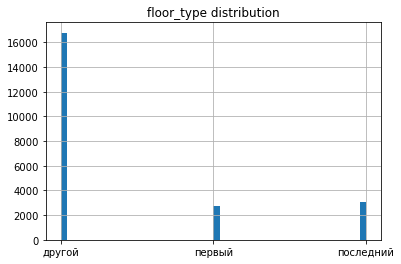

In [70]:
hist = data['floor_type'].hist(bins=50)
plt.title('floor_type distribution');

На первых и последних этажах меньше четверти от общего количества размещенных объявлений.

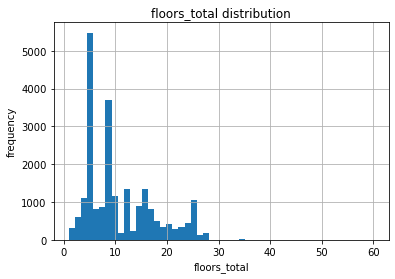

In [71]:
hist = data.hist('floors_total', bins=50)
plt.title('floors_total distribution')
plt.xlabel('floors_total')
plt.ylabel('frequency');

Наиболее распространенная этажность - 5 и 9 этажей.

Скорее всего, в основном, это те самые "хрущевки" и типовые советские панельки.

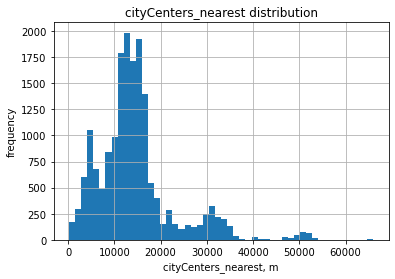

In [72]:
hist = data.hist('cityCenters_nearest', bins=50)
plt.title('cityCenters_nearest distribution')
plt.xlabel('cityCenters_nearest, m')
plt.ylabel('frequency');

Естественно: меньше людей живут в центре, чем на окраинах. 

Судя по графику, в среднем в радиусе 20 км город заканчивается и плотность населения резко снижается.

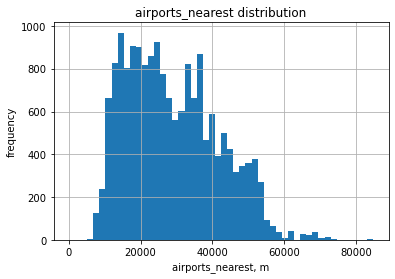

In [73]:
hist = data.hist('airports_nearest', bins=50)
plt.title('airports_nearest distribution')
for ax in hist.flatten():
    ax.set_xlabel('airports_nearest, m')
    ax.set_ylabel('frequency')

Как правило, аэропорты на окраине или вообще за пределами города.

Поэтому и самое популярное расстояние до аэропорта очень близко к предполагаемому среднему радиусу города (20 км).

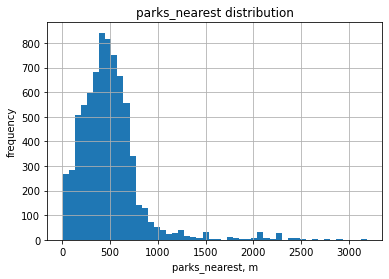

In [74]:
hist = data.hist('parks_nearest', bins=50)
plt.title('parks_nearest distribution')
for ax in hist.flatten():
    ax.set_xlabel('parks_nearest, m')
    ax.set_ylabel('frequency')

Помним, что в столбце _parks_nearest_ было очень много пропусков (больше половины).

Но большинству среди тех, у кого этот параметр указан, есть чем похвастаться - до парка около 500 м. 

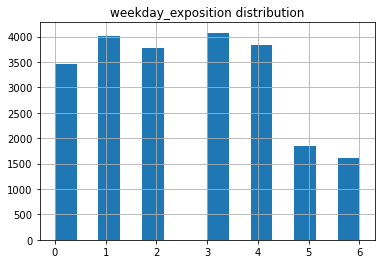

In [75]:
hist = data.hist('weekday_exposition', bins=14)
plt.title('weekday_exposition distribution');

Чаще всего объявляения публикуют в будни: со вторника по пятницу.

По выходным публикуют сильно реже.

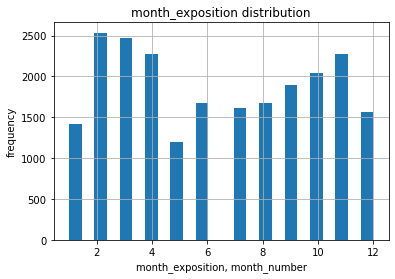

In [76]:
hist = data.hist('month_exposition', bins=24)
plt.title('month_exposition distribution')
plt.xlabel('month_exposition, month_number')
plt.ylabel('frequency');

Чаще всего объявления публиковали в феврале и ноябре.

Реже всего в ноябре и мае.

Заметны также: снижение количества объявлений с февраля по май и рост с августа по ноябрь.

__Исследование скорости продажи квартир__

Построим гистограмму распределения значений

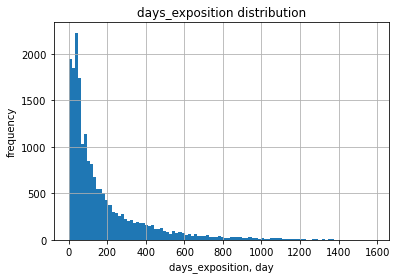

In [77]:
hist = data[data['days_exposition'] > 0].hist('days_exposition', bins=100)
plt.title('days_exposition distribution')
plt.xlabel('days_exposition, day')
plt.ylabel('frequency');

Посчитаем среднее, медиану и процентиль (75%)

In [78]:
print('mean = ', data['days_exposition'].mean())
print('median = ', data['days_exposition'].median())
print('quantile(0.75) =', data['days_exposition'].quantile(0.75))

mean =  178.56773376464844
median =  94.0
quantile(0.75) = 227.0


- по графику видно, что большинство квартир продается быстро. Это подтверждается и значением процентиля - 75% квартир были проданы за 227 дней.
- однако есть и такие объявления, которые висели больше 3 лет. Их значения очень сильно повлияли на среднее арифметическое. Поэтому в данном случае в качестве "среднего" лучше использовать значение медианы.

__Влияние различных параметров на цену квартиры__

_Зависимость цены от общей площади_

In [79]:
# функция для построения графика зависимости цены от выбранного параметра
def create_price_plot(data, col, dimension):
    data.plot(x=col, y='last_price', kind='scatter', alpha=0.3)
    plt.title(f'{col} & last_price scatter plot')
    plt.xlabel(f'{col}, {dimension}')
    plt.ylabel('last_price, rubles')

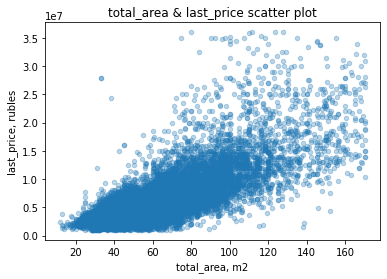

In [80]:
create_price_plot(data, 'total_area', 'm2')

Логично было бы предположить, что вместе с общей площадью растет и цена. График отчасти это подтверждает, но видно, что строгой зависимости нет.

_Зависимость цены от жилой площади_

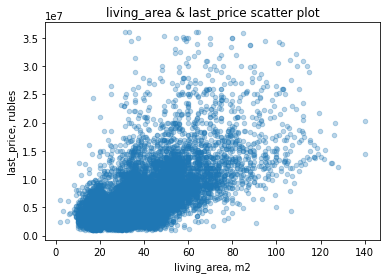

In [81]:
create_price_plot(data, 'living_area', 'm2')

Аналогично: в целом, можно утверждать, что с увеличением жилой площади растет и цена. Но строгой зависимости нет.

_Зависимость цены от площади кухни_

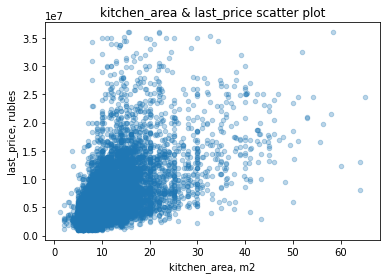

In [82]:
create_price_plot(data, 'kitchen_area', 'm2')

Зависимости цены от площади кухни тоже не наблюдается.

_Зависимость цены от количества комнат_

Создадим сводную таблицу: сгруппируем по количеству комнат и посчитаем медианную стоимость

In [83]:
t = data.pivot_table(index='rooms', values='m2_price', aggfunc='median').reset_index()

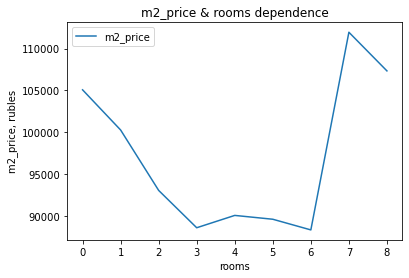

In [84]:
plot = t.plot(x='rooms', y='m2_price')
plt.title('m2_price & rooms dependence')
plt.ylabel('m2_price, rubles');

Цена квадратного метра снижается при увеличении количества комнат от 0 до 3.

Затем с 3 до 6 комнат цента квадратного метра почти не меняется.

При 7 комнатах наблюдается резкий рост - цена за квадратный метр достигает максимума.

Возможно, объекты с 7 и 8 комнатами - уникальные квартиры. Посмотрим.

In [85]:
data[data['rooms'].isin([7,8])]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_nearest,days_exposition,city_name,auto_droped,m2_price,weekday_exposition,month_exposition,year_exposition,floor_type,cityCenters_nearest_km
855,18,15000000.0,134.000000,2017-10-27,7,NaN,4,88.000000,3,False,...,387.0,150.0,Санкт-Петербург,False,111940.296875,4,10,2017,другой,4.0
2039,3,13520000.0,162.800003,2018-03-21,7,3.00,4,121.599998,4,False,...,153.0,NaN,Санкт-Петербург,False,83046.679688,2,3,2018,последний,2.0
2261,15,17800000.0,164.000000,2019-02-12,7,NaN,7,125.900002,7,False,...,397.0,NaN,Санкт-Петербург,False,108536.585938,1,2,2019,последний,3.0
3545,6,13700000.0,154.399994,2017-02-02,7,3.70,5,117.400002,5,False,...,NaN,727.0,Санкт-Петербург,False,88730.570312,3,2,2017,последний,4.0
4159,8,17500000.0,146.300003,2017-11-08,7,3.30,4,108.000000,3,False,...,NaN,NaN,Санкт-Петербург,False,119617.218750,2,11,2017,другой,4.0
8758,5,16100000.0,150.000000,2018-07-10,8,2.92,5,107.000000,1,False,...,NaN,NaN,Санкт-Петербург,False,107333.335938,1,7,2018,первый,5.0
13776,5,30600000.0,162.000000,2018-07-09,7,3.00,5,100.900002,3,False,...,516.0,NaN,Санкт-Петербург,False,188888.890625,0,7,2018,другой,0.0
14603,12,13490000.0,100.599998,2018-07-31,7,NaN,4,NaN,2,True,...,325.0,50.0,Санкт-Петербург,False,134095.421875,1,7,2018,другой,4.0
15196,20,24000000.0,135.000000,2019-05-01,7,3.00,5,75.099998,1,False,...,667.0,NaN,Санкт-Петербург,False,177777.781250,2,5,2019,первый,5.0
17350,18,25000000.0,134.000000,2016-12-01,7,3.29,6,104.000000,2,False,...,584.0,278.0,Санкт-Петербург,False,186567.171875,3,12,2016,другой,6.0


Семи- и восьмикомнатных квартир всего 14 - все они в центре Санкт-Петербурга. Скорее всего, сегмент элитного жилья, а возможно, хорошо сохранишиеся старинные особняки.

_Зависимость цены от типа этажа_

Создадим функцию, которая формирует сводную таблицу: 
- индексы - выбираемый столбец;
- значения - медианные значения стоимости.

Затем по этой таблице строим график типа barchart.

In [86]:
# на вход функции подается датафрейм и столбец, по которому надо сгруппировать данные
def draw_barchart(data, col):
    # группируем данные и считаем медиану по стоимости
    t = data.pivot_table(index=col, values='m2_price', aggfunc='median').reset_index()
    # рисуем barchart
    t.plot.bar(x=col, y='m2_price', rot=0)
    plt.title(f'{col} distribution')
    plt.ylabel('frequency')

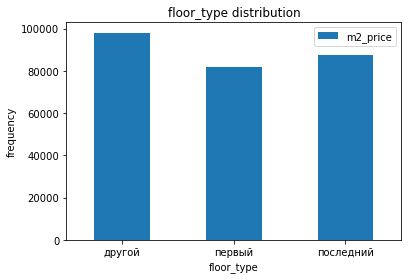

In [87]:
draw_barchart(data, 'floor_type')

В среднем стоимость квартир на первом и последнем этажаж меньше, чем на других. 

_Зависимость цены от дня недели публикации_

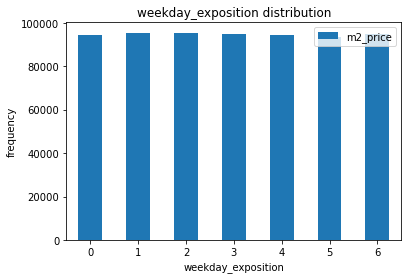

In [88]:
draw_barchart(data, 'weekday_exposition')

Логично: цена квартиры никак не зависит от дня недели, в который опубликовали объявление.

_Зависимость цены от месяца публикации_

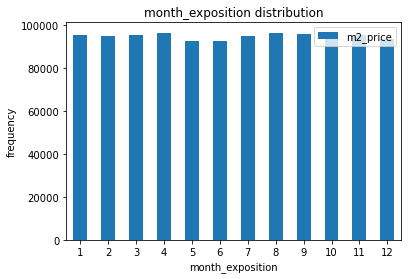

In [89]:
draw_barchart(data, 'month_exposition')

Тоже логично: цена квартиры никак не зависит от месяца, в который опубликовали объявление.

_Зависимость цены от года публикации_

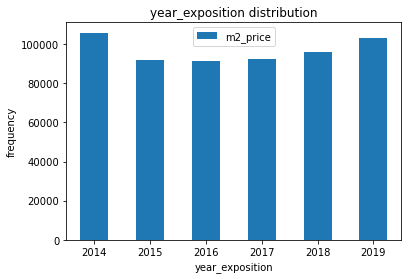

In [90]:
draw_barchart(data, 'year_exposition')

Медианная стоимость квартир заметно снизилась с 2014 по 2016 год. Затем держалась стабильно. 

Однако стоит посмотреть, сколько всего объявлений опубликовано в каждом году.

In [91]:
data['year_exposition'].value_counts()

2018    8196
2017    7841
2019    2759
2016    2622
2015    1093
2014     125
Name: year_exposition, dtype: int64

В 2014 году было опубликовано всего 108 объявлений. Было бы ошибочно делать выводы, основываясь на столь малой выборке.

Скорректируем вывод: с 2015 по 2016 год медианная цена квартир снизилась. В последующие годы она была досточно стабильной.   

_Расчет средней стоимости квадратного метра в 10 населенных пунктах с наибольшим количеством объявлений_

Сохраним в отдельную таблицу 10 городов с наибольшим количеством объявлений

In [92]:
t = (data
 .groupby('city_name')['locality_name'].count()
 .sort_values(ascending=False)
 .reset_index()
 .head(10)
)

In [93]:
top_10_cities = data[data['city_name'].isin(t['city_name'])]
top_10_cities

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_nearest,days_exposition,city_name,auto_droped,m2_price,weekday_exposition,month_exposition,year_exposition,floor_type,cityCenters_nearest_km
0,20,13000000.0,108.000000,2019-03-07,3,2.70,16,51.000000,8,False,...,755.0,NaN,Санкт-Петербург,False,120370.367188,3,3,2019,другой,16.0
1,7,3350000.0,40.400002,2018-12-04,1,NaN,11,18.600000,1,False,...,NaN,81.0,Шушары,False,82920.789062,1,12,2018,первый,19.0
2,10,5196000.0,56.000000,2015-08-20,2,NaN,5,34.299999,4,False,...,574.0,558.0,Санкт-Петербург,False,92785.710938,3,8,2015,другой,14.0
4,2,10000000.0,100.000000,2018-06-19,2,3.03,14,32.000000,13,False,...,48.0,121.0,Санкт-Петербург,False,100000.000000,1,6,2018,другой,8.0
6,6,3700000.0,37.299999,2017-11-02,1,NaN,26,10.600000,6,False,...,NaN,155.0,Парголово,False,99195.710938,3,11,2017,другой,19.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23689,13,3550000.0,35.299999,2018-02-28,1,2.86,15,16.299999,4,False,...,652.0,29.0,Санкт-Петербург,False,100566.578125,2,2,2018,другой,16.0
23690,3,5500000.0,52.000000,2018-07-19,2,NaN,5,31.000000,2,False,...,NaN,15.0,Санкт-Петербург,False,105769.234375,3,7,2018,другой,6.0
23691,11,9470000.0,72.900002,2016-10-13,2,2.75,25,40.299999,7,False,...,806.0,519.0,Санкт-Петербург,False,129903.976562,3,10,2016,другой,4.0
23694,9,9700000.0,133.809998,2017-03-21,3,3.70,5,73.300003,3,False,...,381.0,NaN,Санкт-Петербург,False,72490.843750,1,3,2017,другой,4.0


Группируем данные по городам и считаем среднюю, минимальную и максимальную стоимость квадратного метра и количество объявлений

In [94]:
(top_10_cities
 .pivot_table(index='city_name', values='m2_price', aggfunc=['mean', 'median', 'max', 'min'])
 .reset_index()
 .sort_values(by=('mean', 'm2_price'))
)

,city_name,mean,median,max,min
,,m2_price,m2_price,m2_price,m2_price
1,Выборг,58737.765625,58417.023438,94805.195312,26250.000000
0,Всеволожск,68682.273438,65789.476562,640422.375000,31400.000000
2,Гатчина,68989.468750,67924.531250,146315.796875,10507.246094
3,Колпино,75352.476562,74723.750000,125000.000000,47957.371094
9,Шушары,78528.648438,76666.664062,147826.093750,47700.417969
5,Мурино,85971.304688,86231.882812,138580.234375,50000.000000
6,Парголово,90282.046875,91642.859375,138522.421875,48405.464844
4,Кудрово,95261.960938,95588.234375,160401.000000,54160.343750
7,Пушкин,102374.750000,99725.500000,256521.734375,59836.066406


В среднем самый дорогой квадратный метр, ожидаемо, в Санкт-Петербурге. 

А самый дешевый оказался в Выборге.

Объект с самым дорогим квадратным метром в Санкт-Петербурге - больше 848 тысяч за квадрат.

А объект с самым дешевым квадратным метром - в Гатчине - 10,5 тысяч.

Количество объявлений в Санкт-Петербурге в разы больше суммы объявлений из других городов, что, скорее всего, соответствует их размерам.

__Зависимость цены от удаленности от центра в Санкт-Петербурге__

Создадим таблицу с отфильтрованными данными

In [95]:
spb_data = data[data['city_name'] == 'Санкт-Петербург']

Сгруппируем данные по удаленности от центра и посчитаем для каждой группы медиану

In [96]:
spb_data_grouped = spb_data.groupby('cityCenters_nearest_km')['m2_price'].median()

Построим график зависимости медианной цены квадратного метра от удаленности от центра 

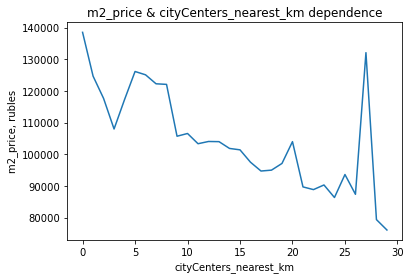

In [97]:
spb_data_grouped.plot(x='index', y='cityCenters_nearest_km')
plt.title('m2_price & cityCenters_nearest_km dependence')
plt.ylabel('m2_price, rubles');

Наблюдается весьма логичная тенденция: чем дальше от центра, тем дешевле квадратный метр.

Но есть довольно сильный выброс на 27 км - посмотрим на объявления оттуда поподробнее.

In [98]:
data[data['cityCenters_nearest_km'] == 27]['city_name'].value_counts()

Пушкин             63
Металлострой       30
Санкт-Петербург     2
Петро-Славянка      1
Александровская     1
Красное Село        1
Name: city_name, dtype: int64

Большинство объявлений из Пушкина и еще треть из Металлостроя - вероятно, действительно, элитные пригороды Санкт-Петербурга. 

Однако при описании линейной взаимосвязи между удаленностью от центра и стоимостью квадратного метра данные с 27 км сильно исказят результат. Поэтому для дальнейших расчетов исключим их и нашей выборки.

In [99]:
spb_data_grouped = spb_data_grouped[spb_data_grouped.index != 27]

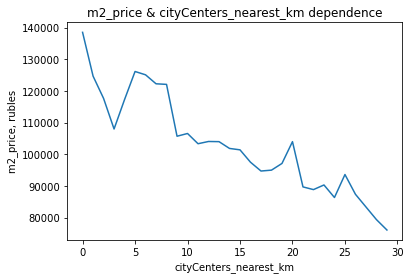

In [100]:
spb_data_grouped.plot(x='index', y='cityCenters_nearest_km')
plt.title('m2_price & cityCenters_nearest_km dependence')
plt.xlabel('cityCenters_nearest_km')
plt.ylabel('m2_price, rubles')
plt.show()

Вычислим коэффициенты a и b для уравнения линейной регрессии (_y = kx + b)_ по формулам:

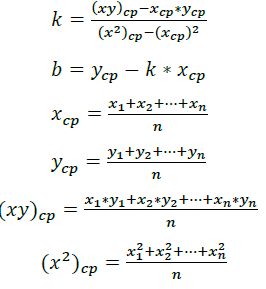

In [101]:
# series to data_frame - для удобства
spb_data_grouped = spb_data_grouped.to_frame().reset_index()

In [102]:
# вычислениия по формулам, приведённым выше
n = len(spb_data_grouped)
x_mean = spb_data_grouped['cityCenters_nearest_km'].mean()
y_mean = spb_data_grouped['m2_price'].mean()
spb_data_grouped['x2'] = spb_data_grouped['cityCenters_nearest_km'].pow(2)
x2_mean = spb_data_grouped['x2'].mean()
spb_data_grouped['xy'] = spb_data_grouped['cityCenters_nearest_km'] * spb_data_grouped['m2_price']
xy_mean = spb_data_grouped['xy'].mean()

In [103]:
# считаем коэффициенты модели линейной регрессии
k = (xy_mean - (x_mean * y_mean)) / (x2_mean - x_mean * x_mean)
b = y_mean - k * x_mean

print(f'k = {k} \nb = {b}')

k = -1643.140740850759 
b = 126870.40761050378


Проверим корректность полученной модели.

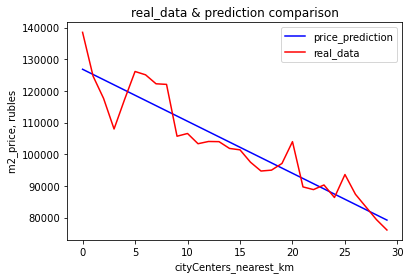

In [104]:
# столбец с расчетным значением стоимости квадратного метра
spb_data_grouped['price_prediction'] = k * spb_data_grouped['cityCenters_nearest_km'] + b

plt.plot(spb_data_grouped['cityCenters_nearest_km'], spb_data_grouped['price_prediction'], 'b-', label='price_prediction')
plt.plot(spb_data_grouped['cityCenters_nearest_km'], spb_data_grouped['m2_price'], 'r-', label='real_data')
plt.legend(loc='best')
plt.title('real_data & prediction comparison')
plt.xlabel('cityCenters_nearest_km')
plt.ylabel('m2_price, rubles')
plt.show()

Полученная модель достаточно хорошо "ложится" на реальные данные.

Поэтому можно утвержать, что в Санкт-Петербурге стоимость квартир с удалением от центра с каждым километром снижается в среднем на 1370.35 (коэффициент k).

### Общий вывод

- чаще всего объявления публикуют в будни (вторник-пятница), сильно реже - в выходные;
- количество объявлений с февраля по май снижается, а с августа по ноябрь - растёт;
- в среднем квартира продается за 107 дней;
- строгих зависимостей цены квартиры от площади кухни, общей или жилой площади не прослеживается;
- в среднем с увеличением количества комнат стоимость квартиры пропорционально растет;
- квартиры на первых и последних этажах в среднем стоят меньше;
- с 2015 по 2016 год медианная цена квартир снизилась, далее до 2019 года - держалась стабильно;
- самый дорогой квадратный метр (111014.23) - в Санкт-Петербурге;
- самый дешевый квадратный метр (58737.77) - в Выборге;
- в Санкт-Петербурге стоимость квартир с удалением от центра с каждым километром снижается в среднем на 1643.14.